In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import math

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
num_epochs = 20
batch_size = 64
learning_rate = 0.1

In [6]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=torchvision.transforms.ToTensor())

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

In [7]:
def show_images(images, title):
        fig, axes = plt.subplots(10, 10, figsize = (10, 10))
        fig.suptitle(title)
        plt.setp(plt.gcf().get_axes(), xticks = [], yticks = [])
        for i, ax in enumerate(axes.flat):
            img = images[i][0].numpy().transpose(1, 2, 0).squeeze(axis = 2)
            ax.imshow(img, cmap = 'gray')

Train data size: 60000
Test data size: 10000


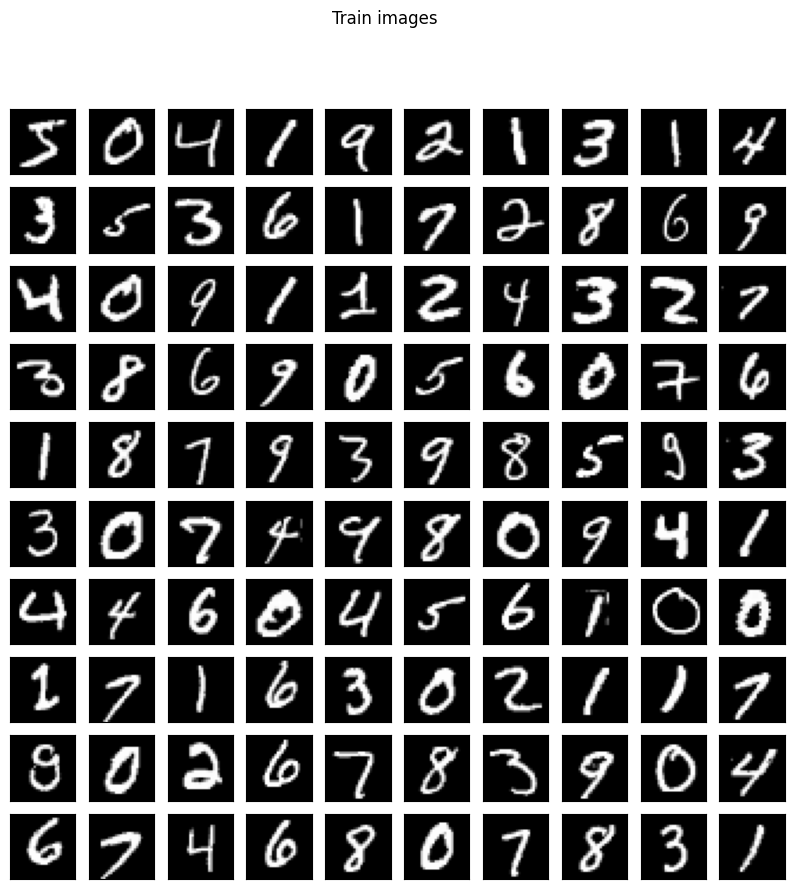

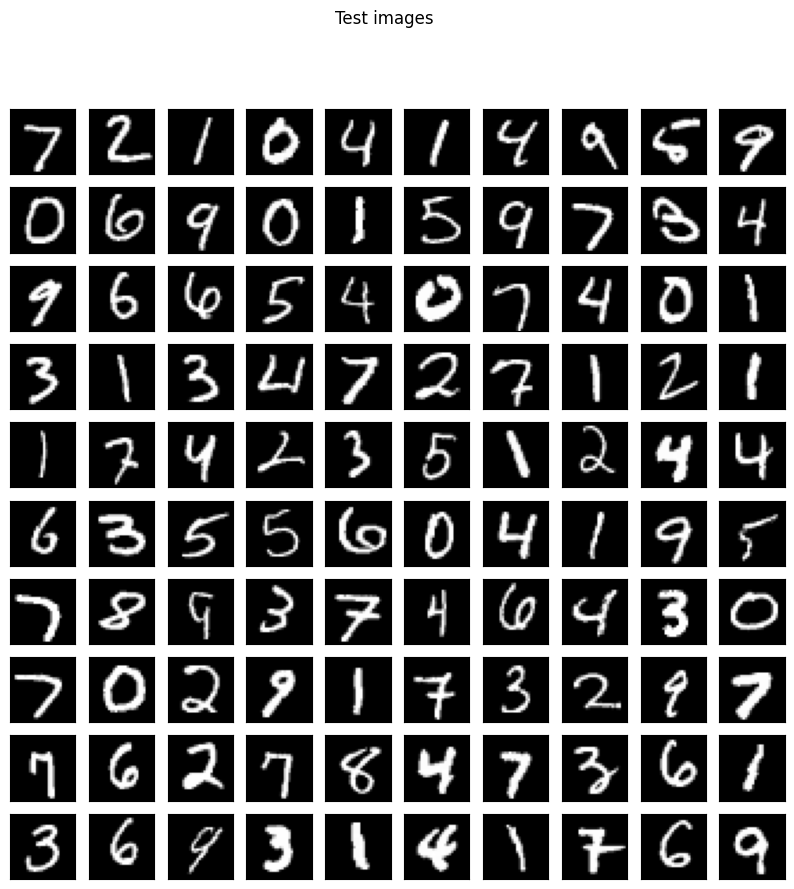

In [8]:
print(f'Train data size: {len(train_dataset)}')
print(f'Test data size: {len(test_dataset)}')
show_images(train_dataset, 'Train images')
show_images(test_dataset, 'Test images')

torch.Size([1, 28, 28])
5


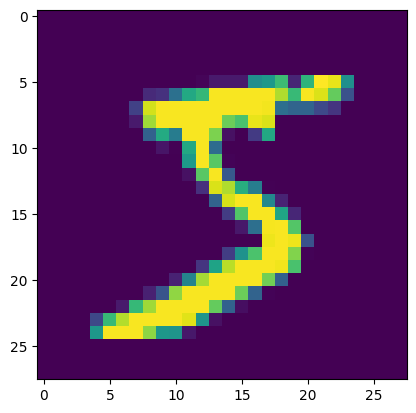

In [9]:
print(f'{train_dataset[0][0].shape}')
print(f'{train_dataset[0][1]}')
plt.imshow(train_dataset[0][0].permute(1, 2, 0))

In [10]:
num_classes = 10
img_resolution = 28*28
hidden_neurons = 300

In [11]:
net = torch.nn.Sequential(
    torch.nn.Linear(img_resolution, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, num_classes)
)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [12]:
net.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=10, bias=True)
)

In [15]:
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.reshape(-1, img_resolution).to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data.to(device), 1)

            predicted = predicted.to(device)
            n += labels.size(dim=0)
            tp += (predicted == labels).sum()
    return tp / n

In [16]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, img_resolution).requires_grad_().to(device)
        labels = labels.to(device)

        outputs = net(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Epoch[{}]: accuracy = {}'.format(epoch, get_accuracy(train_loader, net)))

Epoch[0]: accuracy = 0.9590333700180054
Epoch[1]: accuracy = 0.9675000309944153
Epoch[2]: accuracy = 0.97243332862854
Epoch[3]: accuracy = 0.9767166972160339
Epoch[4]: accuracy = 0.9806833267211914
Epoch[5]: accuracy = 0.9834833145141602
Epoch[6]: accuracy = 0.9861500263214111
Epoch[7]: accuracy = 0.9869999885559082
Epoch[8]: accuracy = 0.9894999861717224
Epoch[9]: accuracy = 0.9885500073432922
Epoch[10]: accuracy = 0.9909166693687439
Epoch[11]: accuracy = 0.9912333488464355
Epoch[12]: accuracy = 0.9935833215713501
Epoch[13]: accuracy = 0.9931333661079407
Epoch[14]: accuracy = 0.9948333501815796
Epoch[15]: accuracy = 0.9958000183105469
Epoch[16]: accuracy = 0.9957666993141174
Epoch[17]: accuracy = 0.996916651725769
Epoch[18]: accuracy = 0.9970499873161316
Epoch[19]: accuracy = 0.9978166818618774


In [17]:
print('Test accuracy: {}'.format(get_accuracy(test_loader, net)))

Test accuracy: 0.9804999828338623


In [42]:
def cross_entropy(predictions, targets):
    ce = - torch.mean(torch.log(predictions) * targets) 
    return ce

In [48]:
class LineralModel:
    def __init__(self, img_resolution, num_classes, hidden_neurons, batch_size, learning_rate):
        self.img_resolution = img_resolution
        self.num_classes = num_classes
        self.hidden_neurons = hidden_neurons
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        self.weights_input_hidden = torch.zeros([self.hidden_neurons, self.img_resolution], dtype=torch.float32)
        self.biases_hidden = torch.zeros([self.hidden_neurons, 1], dtype=torch.float32)
        self.weights_hidden_output = torch.zeros([self.num_classes, self.hidden_neurons], dtype=torch.float32)
        self.biases_output = torch.zeros([self.num_classes, 1], dtype=torch.float32)
        
        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.weights_input_hidden)
        torch.nn.init.zeros_(self.biases_hidden)
        torch.nn.init.xavier_uniform_(self.weights_hidden_output)
        torch.nn.init.zeros_(self.biases_output)

    def __call__(self, images):
        return self.forward(images)

    def forward(self, images: torch.Tensor):
        self.hidden_layer_input = (images @ self.weights_input_hidden.transpose(0, 1).to(device)) + self.biases_hidden.transpose(0, 1).to(device)
        self.hidden_layer_output = torch.relu(self.hidden_layer_input)
        self.output_layer_input = (self.hidden_layer_output @ self.weights_hidden_output.transpose(0, 1).to(device)) + self.biases_output.transpose(0, 1).to(device)
        self.output_layer_output = torch.softmax(self.output_layer_input, 1)
        self.input = images

        return self.output_layer_input

    def backward(self, labels):
        self.weights_input_hidden = self.weights_input_hidden.to(device)
        self.weights_hidden_output = self.weights_hidden_output.to(device)
        self.biases_hidden = self.biases_hidden.to(device)
        self.biases_output = self.biases_output.to(device)

        new_labels = torch.zeros_like(self.output_layer_output)
        for i in range(labels.shape[0]):
            new_labels[i, labels[i]] = 1

        loss = cross_entropy(self.output_layer_output, new_labels)
        output_error = (self.output_layer_output - new_labels) / labels.shape[0]
        hidden_error = torch.mul((output_error.to(device) @ self.weights_hidden_output.to(device)), self.hidden_layer_input > 0)

        self.weights_input_hidden -= learning_rate * (hidden_error.transpose(0, 1).to(device) @ self.input)
        self.weights_hidden_output -= learning_rate * (output_error.transpose(0, 1).to(device) @ self.hidden_layer_output)
        self.biases_hidden -= learning_rate * hidden_error.sum(0).unsqueeze(-1)
        self.biases_output -= learning_rate * output_error.sum(0).unsqueeze(-1)

        return loss

In [49]:
model = LineralModel(img_resolution, num_classes, hidden_neurons, batch_size, learning_rate)

In [50]:
for epoch in range(num_epochs):
    train_losses = []
    for images, labels in train_loader:
        images = images.view(-1, img_resolution).to(device)
        labels = labels.to(device)
        model.forward(images)
        loss = model.backward(labels)
        train_losses.append(loss)
    average_loss = torch.stack(train_losses).mean().item()
    print('Epoch[{}]: accuracy = {} loss = {}'.format(epoch, get_accuracy(train_loader, model), average_loss))

Epoch[0]: accuracy = 0.9390333294868469 loss = 0.03542618453502655
Epoch[1]: accuracy = 0.9586833715438843 loss = 0.018443629145622253
Epoch[2]: accuracy = 0.96711665391922 loss = 0.01374838873744011
Epoch[3]: accuracy = 0.973716676235199 loss = 0.011003891937434673
Epoch[4]: accuracy = 0.9783666729927063 loss = 0.009171481244266033
Epoch[5]: accuracy = 0.980650007724762 loss = 0.00782749429345131
Epoch[6]: accuracy = 0.9818000197410583 loss = 0.006806802935898304
Epoch[7]: accuracy = 0.9857833385467529 loss = 0.0059701609425246716
Epoch[8]: accuracy = 0.9882333278656006 loss = 0.005363037809729576
Epoch[9]: accuracy = 0.9899333715438843 loss = 0.0047785877250134945
Epoch[10]: accuracy = 0.9906333684921265 loss = 0.004316383972764015
Epoch[11]: accuracy = 0.9925166964530945 loss = 0.0038992371410131454
Epoch[12]: accuracy = 0.9931333661079407 loss = 0.0035307283978909254
Epoch[13]: accuracy = 0.9936000108718872 loss = 0.0031906829681247473
Epoch[14]: accuracy = 0.9944666624069214 loss 

In [51]:
print('Test accuracy: {}'.format(get_accuracy(test_loader, model)))

Test accuracy: 0.9794999957084656


In [28]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Метод реализации активационной функции relu
def relu(x):
    return np.maximum(0, x)

# Метод реализации активационной функции softmax
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# Метод расчета кросс-энтропии
def cross_entropy_loss(predictions, targets):
    epsilon = 1e-15
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    N = predictions.shape[0]
    cross_entropy = -np.sum(targets * np.log(predictions + 1e-9)) / N
    return cross_entropy

# Метод реализации One-Hot Encoding
def one_hot_encode(labels, num_classes):
    num_samples = len(labels)
    one_hot_targets = np.zeros((num_samples, num_classes))
    one_hot_targets[np.arange(num_samples), labels] = 1
    return one_hot_targets

# Метод реализации обучения нейронной сети
def train_neural_network(X, y, hidden_size, output_size, learning_rate, num_epochs, batch_size,):
    input_size = X.shape[1]
    num_samples = X.shape[0]

    # Инициализация весов
    weights_input_hidden = np.random.randn(input_size, hidden_size)
    biases_hidden = np.zeros((1, hidden_size))
    weights_hidden_output = np.random.randn(hidden_size, output_size)
    biases_output = np.zeros((1, output_size))

    for epoch in range(num_epochs):
        # Перемешивание данных
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        total_loss = 0
        correct_predictions = 0

        for batch_start in range(0, num_samples, batch_size):
            # Получение пачки данных
            batch_indices = indices[batch_start:batch_start + batch_size]
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

            # Прямой проход
            hidden_layer_input = np.dot(X_batch, weights_input_hidden) + biases_hidden
            hidden_layer_output = relu(hidden_layer_input)
            output_layer_input = np.dot(hidden_layer_output, weights_hidden_output) + biases_output
            output_layer_output = softmax(output_layer_input)

            # Расчет ошибки
            loss = cross_entropy_loss(output_layer_output, y_batch)
            total_loss += loss

            # Расчет accuracy
            predictions = np.argmax(output_layer_output, axis=1)
            true_labels = np.argmax(y_batch, axis=1)
            correct_predictions += np.sum(predictions == true_labels)

            # Обратный проход (обновление весов)
            output_error = output_layer_output - y_batch
            hidden_error = np.dot(output_error, weights_hidden_output.T) * (hidden_layer_output > 0)

            weights_hidden_output -= learning_rate * np.dot(hidden_layer_output.T, output_error)
            biases_output -= learning_rate * np.sum(output_error, axis=0, keepdims=True)
            weights_input_hidden -= learning_rate * np.dot(X_batch.T, hidden_error)
            biases_hidden -= learning_rate * np.sum(hidden_error, axis=0, keepdims=True)

        average_loss = total_loss / (num_samples / batch_size)
        accuracy = correct_predictions / num_samples

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")
        
    return weights_input_hidden, biases_hidden, weights_hidden_output, biases_output

# Загрузка данных MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Преобразование изображений в одномерные векторы и нормализация значений
X_train = X_train.reshape((X_train.shape[0], -1)) / 255.0
X_test = X_test.reshape((X_test.shape[0], -1)) / 255.0

# Преобразование меток классов в One-Hot Encoding формат
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Параметры нейронной сети
hidden_size = 128
output_size = 10
learning_rate = 0.01
num_epochs = 20
min_batch_size = 64
max_batch_size = 64

batch_size = 64

train_neural_network(X_train, y_train_one_hot, hidden_size, output_size, learning_rate, num_epochs, batch_size)

Epoch 1/20, Loss: 0.9492, Accuracy: 0.7954
Epoch 2/20, Loss: 0.4015, Accuracy: 0.8916
Epoch 3/20, Loss: 0.3134, Accuracy: 0.9156
Epoch 4/20, Loss: 0.2696, Accuracy: 0.9262
Epoch 5/20, Loss: 0.2369, Accuracy: 0.9341
Epoch 6/20, Loss: 0.2143, Accuracy: 0.9398
Epoch 7/20, Loss: 0.1956, Accuracy: 0.9451
Epoch 8/20, Loss: 0.1813, Accuracy: 0.9495
Epoch 9/20, Loss: 0.1679, Accuracy: 0.9524
Epoch 10/20, Loss: 0.1543, Accuracy: 0.9562
Epoch 11/20, Loss: 0.1463, Accuracy: 0.9587
Epoch 12/20, Loss: 0.1381, Accuracy: 0.9602
Epoch 13/20, Loss: 0.1273, Accuracy: 0.9631
Epoch 14/20, Loss: 0.1237, Accuracy: 0.9645
Epoch 15/20, Loss: 0.1168, Accuracy: 0.9669
Epoch 16/20, Loss: 0.1101, Accuracy: 0.9678
Epoch 17/20, Loss: 0.1051, Accuracy: 0.9695
Epoch 18/20, Loss: 0.0999, Accuracy: 0.9708
Epoch 19/20, Loss: 0.0968, Accuracy: 0.9716
Epoch 20/20, Loss: 0.0909, Accuracy: 0.9736


(array([[-1.05607017,  0.37190408, -1.02430123, ...,  1.1397479 ,
          0.16792866, -1.80353141],
        [ 0.05052831, -0.00319082,  0.68805085, ...,  1.77196808,
         -0.26897282, -0.84935495],
        [-0.10209363, -0.1705263 , -1.31568519, ...,  0.37896039,
         -0.65485584, -1.21543421],
        ...,
        [-0.10381697,  2.95725125,  0.16313243, ..., -1.92524084,
         -0.71084219, -2.04478535],
        [ 0.60049526, -1.0750147 , -0.92593411, ...,  0.19033643,
         -1.02563608,  0.82803851],
        [ 1.91553054,  1.38676489,  0.60956034, ...,  0.00524974,
          0.43122829,  0.27520802]]),
 array([[-0.90756328, -0.53005946, -1.14044366, -0.58057885, -0.79654717,
         -0.56046092, -0.33833078, -0.64479026, -1.40923462, -0.37472887,
         -0.77965058, -0.42194687, -0.52227924, -0.707191  , -0.29339804,
         -0.61530612, -0.88762015, -0.73034404, -0.45112906, -0.86714939,
         -0.73226633, -0.72977995, -0.55534715, -0.69753417, -0.05840099,
   